# **Project - Market Making**

This project simulates a basic inventory-aware market-making strategy using Level-2 (L2) order book data from Bybit for the BTCUSDT perpetual futures contract. The strategy posts both bid and ask quotes, tracks fills, updates position and PnL, and logs real-time performance through mark-to-market valuations. The primary goal is to gain insight into how passive quoting behaves under inventory and execution constraints in real-world high-frequency data.

In [51]:
pip install ujson

In [52]:
import ujson
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Formatting Data

The historical order book data used in this project was downloaded and formatted following the method described in [this article by Lu Battistoni](https://medium.com/@lu.battistoni/how-to-download-and-format-free-historical-order-book-dataset-16b3a84a8e0e).
The `OrderBookLoader` class is designed to efficiently load, parse, and visualize high-frequency L2 order book data from Bybit, enabling structured analysis and market depth visualization for quantitative research or trading simulations.

In [53]:
class OrderBookLoader:
    """
    Fast order book loader using ujson and numpy
    Stores L2 snapshots (asks and bids) per timestamp.
    """
    def __init__(self, file_path, max_depth=1, rows_to_process=None):
        self.file_path = file_path
        self.max_depth = max_depth
        self.rows_to_process = rows_to_process
        self.nrows = None
        self.order_books = {}  # {timestamp: {'ask': np.array, 'bid': np.array}}
        self.timestamps = []

    def number_of_rows(self):
        """Return total number of lines in the data file."""
        if(self.nrows):
            return self.nrows
        with open(self.file_path, 'r') as f:
            self.nrows = sum(1 for _ in f)
        return self.nrows

    def read_data(self):
        """
        Read up to `rows_to_process` lines, parse JSON via ujson,
        and store top `max_depth` levels in numpy arrays.
        """
        # Determine how many rows to process
        if self.rows_to_process is None:
            self.rows_to_process = self.number_of_rows()

        with open(self.file_path, 'r') as f:
            for _ in tqdm(range(self.rows_to_process), desc="Loading order book "):
                line = f.readline().strip().strip("'")
                if not line:
                    break
                obj = ujson.loads(line)

                ts = obj['ts']
                a = obj['data']['a'][:self.max_depth]
                b = obj['data']['b'][:self.max_depth]

                # skip incomplete snapshots
                if not a or not b:
                    continue

                # store as numpy arrays of shape (depth, 2): [price, volume]
                self.order_books[ts] = {
                    'ask': np.array(a, dtype=np.float64),
                    'bid': np.array(b, dtype=np.float64)
                }
        self.timestamps = list(self.order_books.keys())
        self.timestamps.sort()

## Testing if it works

Let's take an overview of number of data points and general look of the data file

In [54]:
# file name
path = '/content/2025-06-09_BTCUSDT-26SEP25_ob500.txt'

# Instantiate the loader with the file
loader = OrderBookLoader(path, max_depth = 3, rows_to_process = 100000)

# Number of rows
max_n_of_rows = loader.number_of_rows()
print(max_n_of_rows)

# number of datapoints in a second
print(max_n_of_rows / (60 * 60 * 24), "per second")

# Read data from the file
loader.read_data()

# Build a structured order book Dictionary
order_books = loader.order_books
time = loader.timestamps

499450
5.780671296296297 per second


Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 170731.83it/s]


In [55]:
order_books[time[0]]['bid'][:,0] # bid prices

array([107882.1, 107871.2, 107863.8])

In [56]:
order_books[time[0]]['ask'][:,0] # ask prices

array([107887.2, 107907.7, 107909.1])

## Helper Classes

In [57]:
# Class for a single order
class Order:
  def __init__(self, Side, Price, Vol, Timestamp):
    # quote = [price,vol,timestamp]
    self.side = Side
    self.price = Price
    self.vol = Vol
    self.timestamp = Timestamp
    # info at the time of order creation

  def __lt__(self, other): # Defining < operation
    # For price-time priority in the heap (buy orders: max-heap, sell orders: min-heap)
    if self.side == 'buy':
        return self.price > other.price if self.price != other.price else self.timestamp < other.timestamp
    else:
        return self.price < other.price if self.price != other.price else self.timestamp < other.timestamp

The `INVENTORY` class tracks active quotes, manages inventory, and computes PnL for a market-making strategy.

This class simulates the internal bookkeeping of a market maker operating on a limit order book.
It records quotes placed on both the bid and ask side, tracks inventory exposure, executes trades based on live market updates, and calculates mark-to-market profit or loss (PnL).

Its attributes are as follows:

    active_bids : dict
        Active bid quotes keyed by internal index.
    active_asks : dict
        Active ask quotes keyed by internal index.
    index : int
        Sequential counter for quote entries.
    position : int
        Net position held by the market maker (positive for long, negative for short).
    pnl : float
        Realized profit or loss.
    tot_spread : float
        Tracks total spread accumulated.
    base_vol : float
        Volume of each order.
    pnl_history : list
        Stores tuples of (timestamp, mark-to-market PnL) for plotting.
    time_limit : int
        Maximum time a quote is allowed to live before expiring (in quote indices).

The `add_quote` function adds new bid and ask quotes to active memory.

The `execute` function executes quotes if crossed by new trades and updates PnL and position. `bid_traded` and `ask_traded` are boolean parameters to make note if bid or ask can possibly be filled.

In [58]:
class INVENTORY:
  #Initialise the inventory
  def __init__(self, Time_limit = 100):
    # Among all our outstanding bid quotes, the highest bid is the most urgent or likely to get filled.
    # Each quote_dict element {'price', 'vol', 'time'}
    self.active_bids = {} # dict: (index, Order)
    self.active_asks = {} # dict: (index, Order)
    self.index = 0
    self.position = 0 # Positive means we're long, negative means we're short
    self.pnl = 0 # Profit if +ve else -ve
    self.tot_spread = 0
    self.base_vol = 0.001
    self.plot_history = []
    self.pnl_history = []
    self.loss_history = [] # Asymmetric loss
    self.time_limit = Time_limit # in terms of indices, later modify it to real-time

  def add_quote(self, bid_quote, bid_vol , ask_quote, ask_vol, current_time):
    # bid_quote = [price , vol, time_stamp]
    # ask_quote = [price , vol, time_stamp]
    self.active_bids[self.index] = Order('buy', bid_quote, bid_vol, current_time)
    self.active_asks[self.index] = Order('sell', ask_quote, ask_vol, current_time)
    self.index += 1

  def execute(self, bid_traded, best_bid, ask_traded, best_ask, current_time):
    if self.active_bids and bid_traded and (best_bid is not None):
      rem_ids = []
      for idx, bid in list(self.active_bids.items()):
        # if bid.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (bid.price >= best_bid):
            rem_ids.append(idx)
            self.position += bid.vol/self.base_vol
            self.pnl -= bid.vol * bid.price
      for id in rem_ids:
        del self.active_bids[id]

    if self.active_asks and ask_traded and (best_ask is not None):
      rem_ids = []
      for idx,ask in list(self.active_asks.items()):
        # if ask.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (ask.price <= best_ask):
            rem_ids.append(idx)
            self.position -= ask.vol/self.base_vol
            self.pnl += ask.vol * ask.price
      for id in rem_ids:
        del self.active_asks[id]

  def mark_to_market(self, best_bid, best_ask):
    if (best_bid is None) or (best_ask is None):
        return self.pnl

    if self.position >= 0:
        # You're long → you’d sell at bid
        return self.pnl + self.position * best_bid
    else:
        # You're short → you’d buy back at ask
        return self.pnl + self.position * best_ask

  def plot_pnl(self):
    times_plot, data = zip(*self.plot_history)
    pnl_values = [item[0] for item in data]
    spread_values = [item[1] for item in data]

    # Plot PnL and Spread
    plt.figure(figsize=(10, 5))
    plt.plot(times_plot, pnl_values, label="PnL", color= 'blue')
    plt.plot(times_plot, spread_values, label="Spread", color='orange', linestyle='--')

    # Labels and legend
    plt.xlabel("Time (Index or Timestamp)")
    plt.ylabel("Value")
    plt.title("PnL and Spread of Market-Maker During the Day")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Quoting Logic

$$ min\_price : \Delta = 0.1 $$
$$ price\_factor : \alpha = 1.0 $$
$$ Inventory\_bias : \phi = \frac{I}{I_{max}} $$

### Price

$$ bid\_quote = best\_bid + \Delta - \alpha . \phi . \Delta $$
$$ ask\_quote = best\_ask - \Delta - \alpha . \phi . \Delta $$

### Volume

$$ base\_volume : Q_0 = 0.001 $$
$$ vol\_factor : \beta = 1.0 $$
$$ $$
$$ bid\_vol = Q_0 (1 - \beta . \Delta) $$
$$ ask\_vol = Q_0 (1 + \beta . \Delta) $$


`delta` represents the tick size, i.e. the smallest possible increment in price. If `spread < 2 * delta`, we don't quote because the spread is too thin.

Using `skew = max(abs(inventory_vol / max_inventory), 1)`, we ensure that even at small inventory, we still apply a minimum bias to discourage further accumulation(aggresive strategy). We make the skew negative if we are net short.

`price_factor` lets us amplify how aggresively we want to shift.

If skew > 0 (long), both quotes shift down → makes buying less attractive and selling more tempting.

If skew < 0 (short), both quotes shift up → makes buying more attractive (to cover) and selling less attractive.

If `market_neutral is True`, we ignore all inventory bias. Both bid and ask are sized at base_vol. Otherwise, we scale volumes in the opposite direction of unwanted inventory.

In [59]:
# Using inventory bias and unequal quoting
def quotes(best_bid, best_ask, delta=0.1, inventory_vol=0, price_factor=1.0, vol_factor=0.5, base_vol=0.001, max_inventory=1.0, market_neutral=False):
    '''
    delta : tick_size
    price_factor : affects how much price is affected by inventory (>= 1)
    vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    base_vol : base volume
    max_inventory : max inventory size
    '''
    if (best_bid is None) or (best_ask is None):
        return None

    spread = best_ask - best_bid
    if(spread < 2 * delta): # Only quote if we have a proper spread
        return None

    skew = min(abs(inventory_vol / max_inventory), 1)
    if(inventory_vol < 0) :
        skew = -skew # Negative skew if we are net short
    skew_price = round(skew * price_factor * delta, 1) # Price offset

    bid_quote = best_bid + delta - skew_price
    ask_quote = best_ask - delta - skew_price

    if market_neutral:
        return bid_quote, base_vol, ask_quote, base_vol # MARKET NEUTRAL

    bid_vol = base_vol * (1 - vol_factor * skew)
    ask_vol = base_vol * (1 + vol_factor * skew)

    if (bid_vol < 0) or (ask_vol < 0):
        return None

    # Round to tick size if necessary
    return bid_quote, bid_vol, ask_quote, ask_vol

## Market Strategy

In the following code snippet, we make quotes and calculate profit and loss for one day.

`quote_interval` represents after how many time stamps do we need to make a quote i.e. we make a quote after every `quote_interval` number of time stamps.

We enumerate through every time stamp of the day and find the `best_bid` and `best_ask`. `prev_best_bid` and `prev_best_ask` store the best bid and ask for the order book of the previous day. If the best bid has reduced from the previous day or the best ask has increased, that implies if we made a quote at that, our order would get filled. This is a heuristic approach. Accordingly, we try all out active bids and asks on the current order book.

Then, at `quote_interval`, we make new quotes.

In [60]:
def hourly_pnl(loader, quote_interval=1, exit_interval=100, Price_factor=4.0, Vol_factor=0.5, Max_inventory=1.0, MARKET_NEUTRAL=False):
    """
    Simulate PnL of one day by iterating over L2 snapshots in order_books.
    Uses numpy arrays directly, no pandas.
    exit_interval : indices of order books before the quote orders are taken back
    Price_factor : affects how much price is affected by inventory (>= 1)
    Vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    quote_interval : frequency at which we release new quotes

    Vol_factor = 0 essentially implies market neutrality
    """
    # Load order books
    order_books = loader.order_books
    times = loader.timestamps

    # Initialize inventory
    inventory = INVENTORY(exit_interval)
    base_vol = inventory.base_vol
    prev_best_bid = prev_best_ask = None

    for idx, t in enumerate(times):
        book = order_books[t]

        # best prices & vols
        if book['bid'].size:
            best_bid = (book['bid'][0,0], book['bid'][0,1])
        else:
            best_bid = None
        if book['ask'].size:
            best_ask = (book['ask'][0,0], book['ask'][0,1])
        else:
            best_ask = None

        # detect trade-through
        bid_traded = False
        ask_traded = False
        if (prev_best_bid) and (best_bid):
            bid_traded = ((best_bid[0] < prev_best_bid[0]) or
                          ((best_bid[0] == prev_best_bid[0]) and (best_bid[1] < prev_best_bid[1])))
        if (prev_best_ask) and (best_ask):
            ask_traded = ((best_ask[0] > prev_best_ask[0]) or
                          ((best_ask[0] == prev_best_ask[0]) and (best_ask[1] < prev_best_ask[1])))

        # execute fills
        if bid_traded or ask_traded:
            inventory.execute(
                bid_traded, best_bid[0],
                ask_traded, best_ask[0],
                t
            )

        prev_best_bid, prev_best_ask = best_bid, best_ask

        # quote every N steps
        if (idx % quote_interval == 0) and (best_bid is not None) and (best_ask is not None):
            new_quotes = quotes(best_bid[0], best_ask[0], delta=0.1, inventory_vol=inventory.position, price_factor=Price_factor, vol_factor=Vol_factor, base_vol=base_vol, max_inventory=Max_inventory, market_neutral=MARKET_NEUTRAL)
            if new_quotes:
                bid_q, bid_v, ask_q, ask_v = new_quotes
                if (bid_q is not None) and (ask_q is not None):
                    inventory.add_quote(bid_q, bid_v, ask_q, ask_v, t)

        # PnL logging
        # mtm = inventory.mark_to_market(best_bid[0],best_ask[0])
        inventory.tot_spread += (best_ask[0] - best_bid[0]) * base_vol
        inventory.pnl_history.append(inventory.pnl)
        inventory.plot_history.append((t, [inventory.pnl, inventory.tot_spread]))

    # final metrics
    last_book = order_books[times[-1]]
    print(f"Final Inventory: {round(inventory.position,2)} | Final PNL: {round(inventory.pnl,2)}")
    print(f"PNL to Spread Ratio: {inventory.pnl / inventory.tot_spread:.4f}")
    inventory.plot_pnl()

## Analysis

The blue line shows a steadily increasing PnL with some volatility, while the orange dashed line reflects cumulative spread capture, which rises consistently to over 8500. A PnL-to-Spread ratio of 0.75 indicates efficient spread capture, with 75% of earned spread converting into profit

Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 148653.11it/s]


Final Inventory: -5.0 | Final PNL: 6571.06
PNL to Spread Ratio: 0.7528


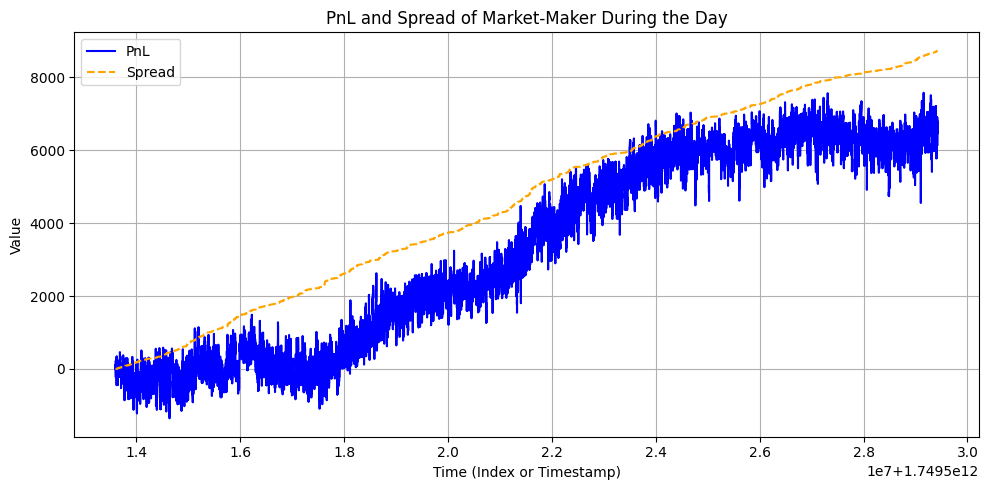

In [61]:
path = '/content/2025-06-10_BTCUSDT-26SEP25_ob500.txt'
loader = OrderBookLoader(path, rows_to_process = 100000)
loader.read_data()
hourly_pnl(loader, quote_interval=1, exit_interval=100, Price_factor=4.0, Vol_factor=0.5, Max_inventory=1.0, MARKET_NEUTRAL=True)

### One Good Set of HyperParameters

Final Inventory: -1.56 | Final PNL: 7525.48
PNL to Spread Ratio: 0.8621


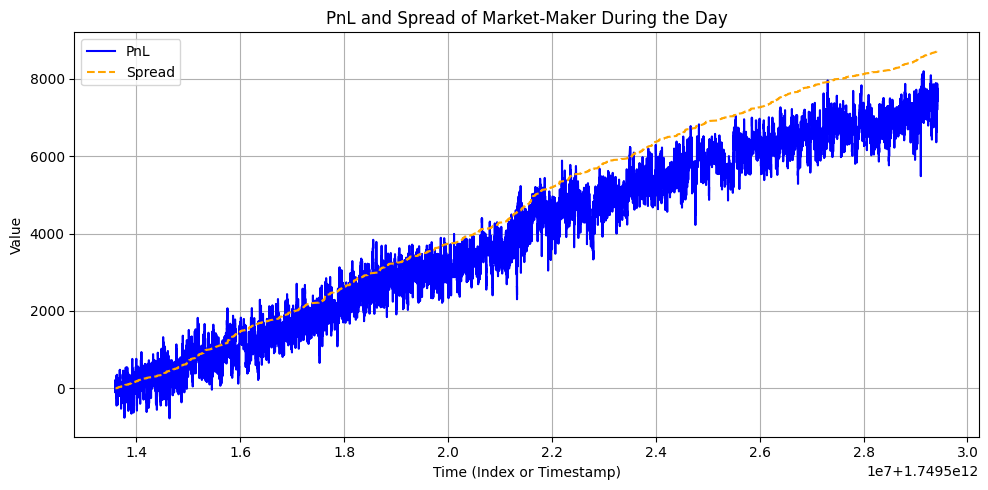

In [62]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.009, Max_inventory=0.5)

Final Inventory: -1.76 | Final PNL: 7475.25
PNL to Spread Ratio: 0.8563


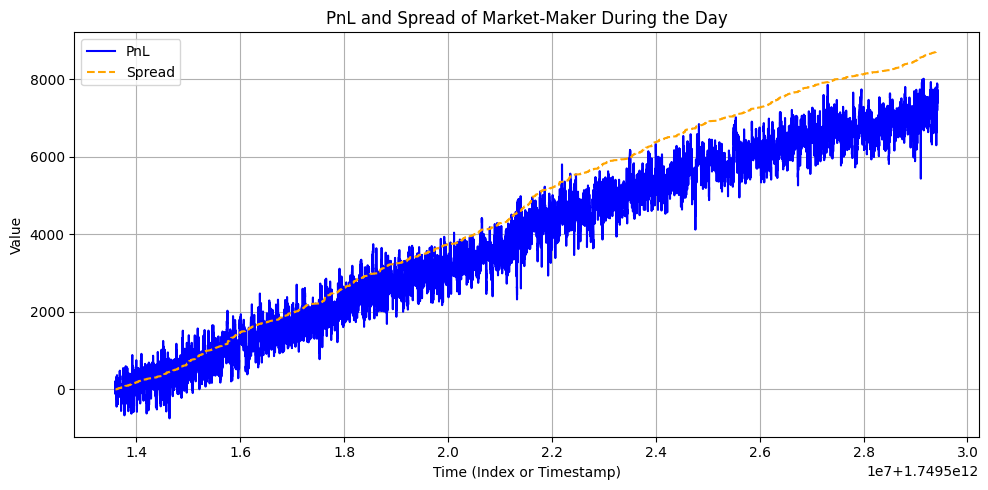

In [63]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.025, Max_inventory=0.5)

Final Inventory: -1.69 | Final PNL: 7491.04
PNL to Spread Ratio: 0.8581


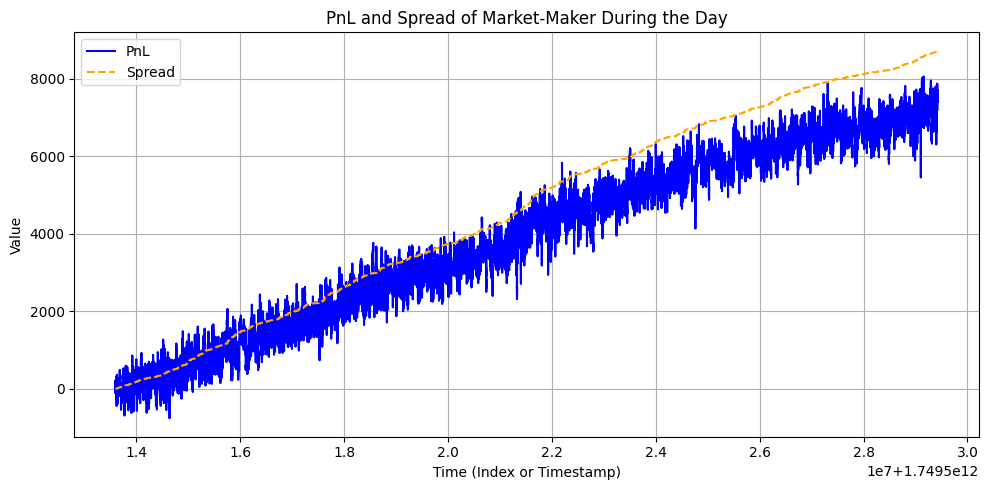

In [64]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.020, Max_inventory=0.5)

Final Inventory: -1.76 | Final PNL: 7452.65
PNL to Spread Ratio: 0.8537


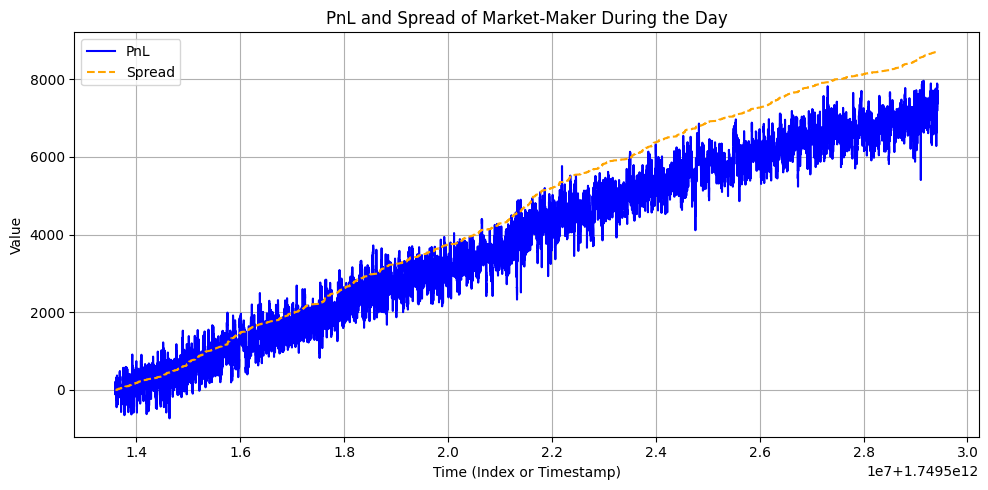

In [65]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.03, Max_inventory=0.5)

Final Inventory: -1.59 | Final PNL: 7391.46
PNL to Spread Ratio: 0.8467


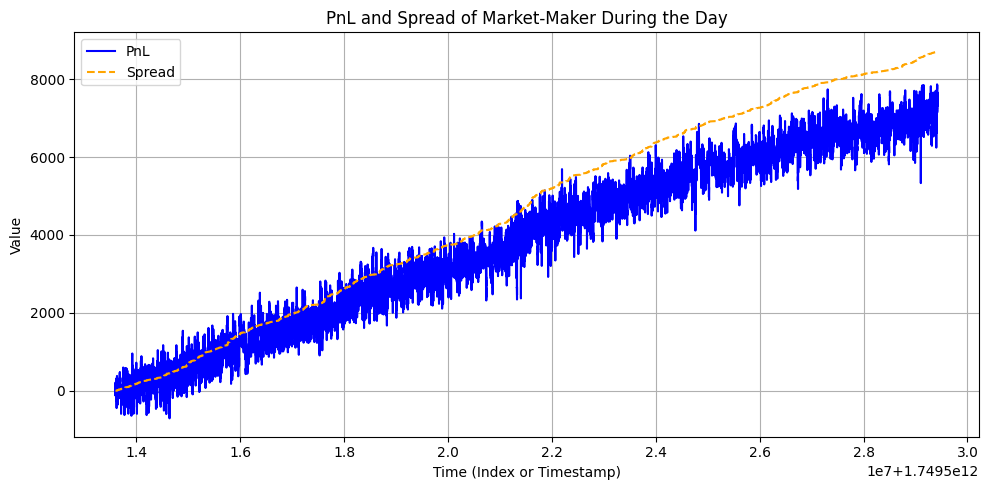

In [66]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.04, Max_inventory=0.5)

Final Inventory: -1.59 | Final PNL: 7502.25
PNL to Spread Ratio: 0.8594


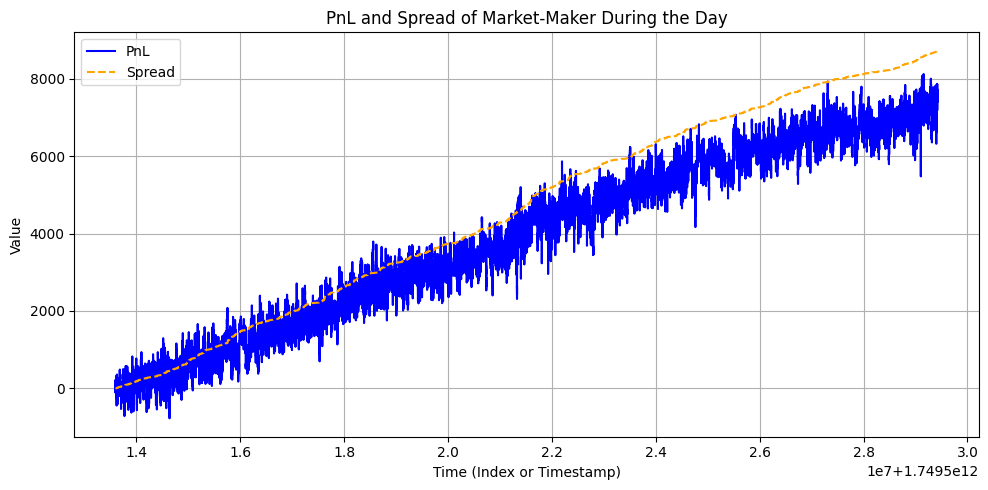

In [67]:
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.015, Max_inventory=0.5)


**Let's see if it works on the entire day**

Loading order book : 100%|██████████| 449923/449923 [00:04<00:00, 106350.58it/s]


Final Inventory: 0.96 | Final PNL: 42353.56
PNL to Spread Ratio: 0.8432


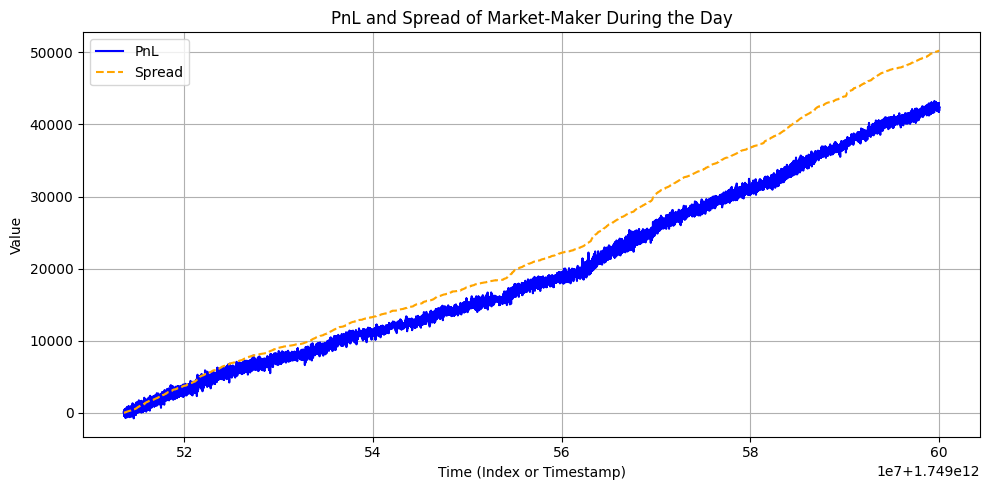

In [68]:
loader = OrderBookLoader(path) # ENTIRE DATASET
loader.read_data()
hourly_pnl(loader,exit_interval=250, Price_factor=1, Vol_factor=0.012, Max_inventory=0.5)

Infact, this time we got an even better performance

**Let's see if it works decently on the next day for the same instrument**

Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 152400.22it/s]


Final Inventory: -2.87 | Final PNL: 7071.11
PNL to Spread Ratio: 0.8764


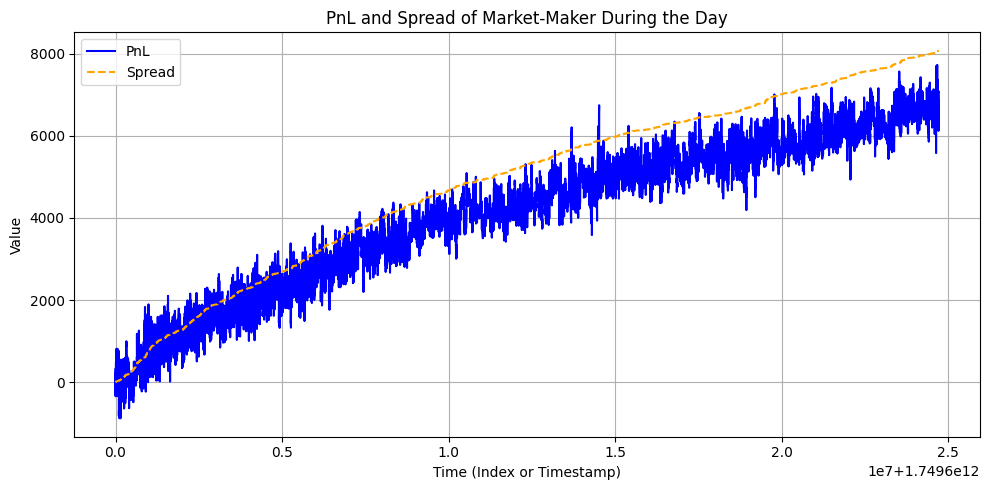

In [69]:
path2 = '/content/2025-06-11_BTCUSDT-26SEP25_ob500.txt'
loader2 = OrderBookLoader(path2, rows_to_process = 100000)
loader2.read_data()
hourly_pnl(loader2,exit_interval=250, Price_factor=1, Vol_factor=0.013, Max_inventory=0.5)

Loading order book : 100%|██████████| 528366/528366 [00:04<00:00, 107380.80it/s]


Final Inventory: 4.93 | Final PNL: 29649.27
PNL to Spread Ratio: 0.7375


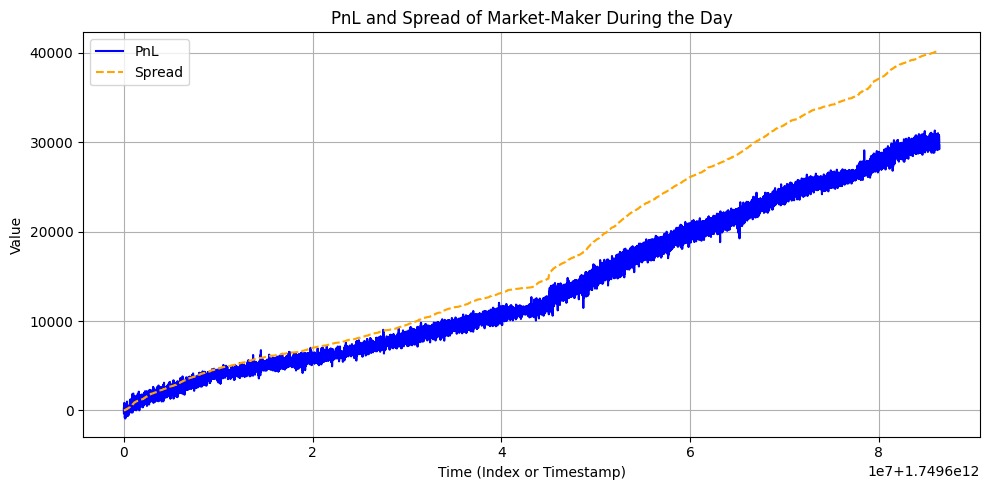

In [70]:
loader2 = OrderBookLoader(path2)
loader2.read_data()
hourly_pnl(loader2,exit_interval=250, Price_factor=1, Vol_factor=0.013, Max_inventory=0.5)

### Day after the next day

Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 118695.54it/s]


Final Inventory: -3.55 | Final PNL: 5082.76
PNL to Spread Ratio: 0.7808


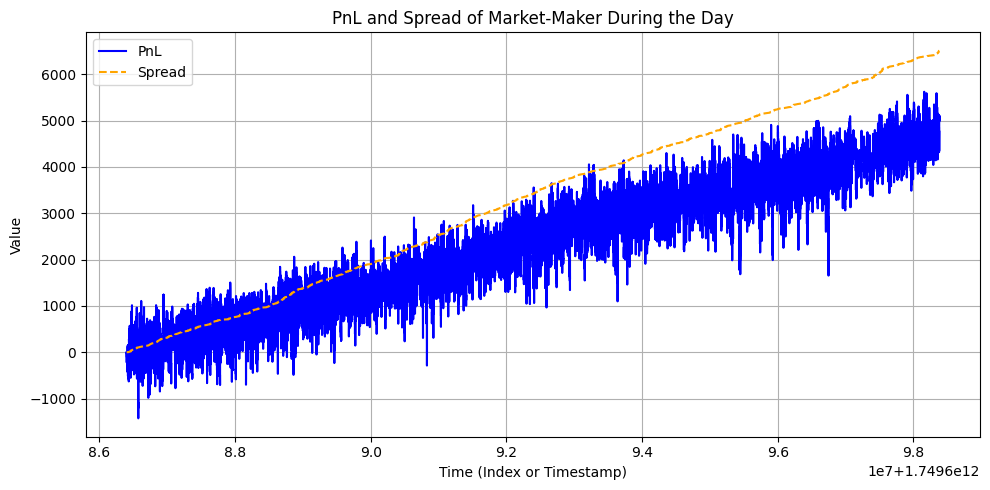

In [71]:
path3 = '/content/2025-06-12_BTCUSDT-26SEP25_ob500.txt'
loader3 = OrderBookLoader(path3, rows_to_process = 100000)
loader3.read_data()
hourly_pnl(loader3,exit_interval=250, Price_factor=1, Vol_factor=0.013, Max_inventory=0.5)

and for the entire day :

Loading order book : 100%|██████████| 602434/602434 [00:05<00:00, 117877.63it/s]


Final Inventory: 1.4 | Final PNL: 47043.52
PNL to Spread Ratio: 0.7948


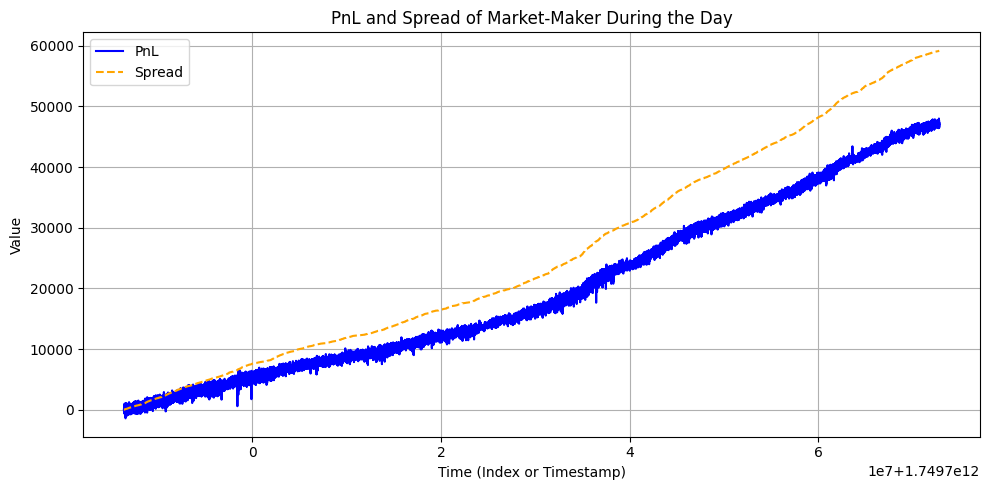

In [72]:
loader3 = OrderBookLoader(path3)
loader3.read_data()
hourly_pnl(loader3,exit_interval=250, Price_factor=1, Vol_factor=0.013, Max_inventory=0.5)